# Retrieval-Augmented Generation (RAG)

Retrieval-Augmented Generation (RAG) is an advanced AI framework that combines information retrieval with text generation models like GPT to produce more accurate and up-to-date responses. Instead of relying only on pre-trained data like traditional language models, RAG fetches relevant documents from an external knowledge source before generating an answer.

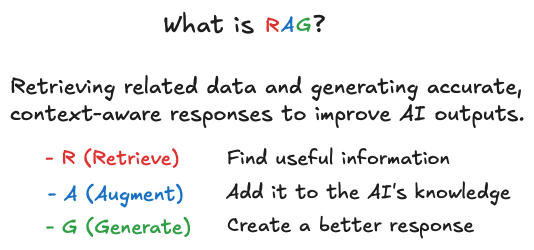

## Importance of RAG

- **Access to current information:** Uses external sources to go beyond the model’s training data.
- **Better answer quality:** Reduces hallucinations.
- **Support for specific domains:** Works with specialized data without retraining the model.
- **Efficient updates:** New information can be added without rebuilding the model.
- **User-aware responses:** Allows responses to be adapted using user context.


## Components of RAG

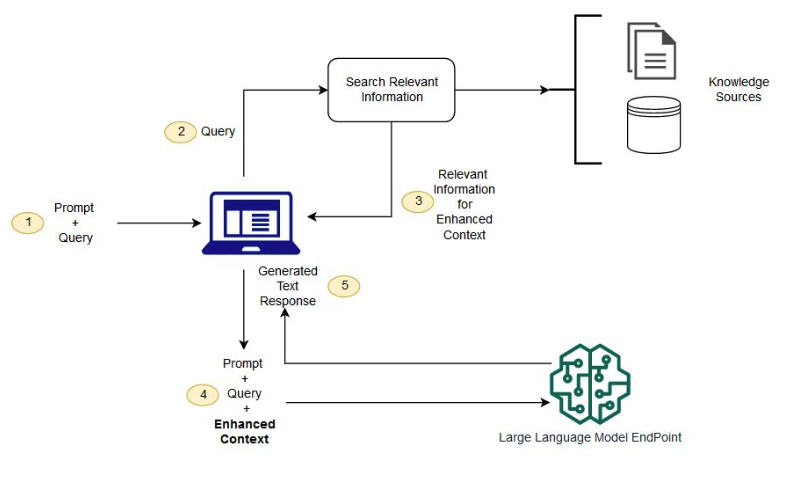

1. **User Prompt and Query**: The user submits a question and prompt to the system.
2. **Query Processing and Search**: The query is sent to a search component to find relevant information.
3. **Retrieval from Knowledge Sources**: Relevant documents or data are retrieved from external knowledge sources.
4. **Context Enhancement**: The retrieved information is combined with the original prompt and query to create an enhanced context.
5. **Response Generation**: The enhanced context is sent to the Large Language Model, which generates the final response.

## Exercise Structure

This exercise is divided into **two main parts**, following the standard RAG workflow:
1. **Indexing**: In this part, we will build a pipeline for ingesting data from a source and indexing it.  
2. **Retrieval and Generation**: In this part, we will implement the actual RAG process.  

### Indexing

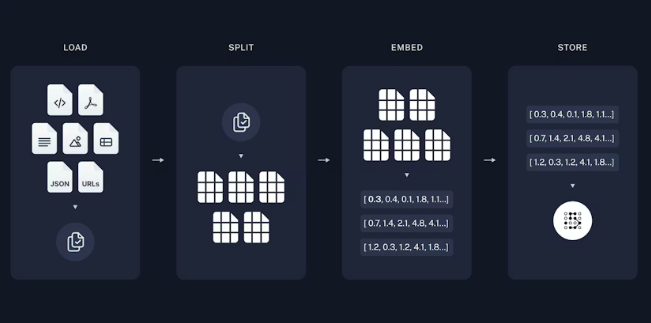

The indexing process typically consists of the following steps:

1. **Load**: Data is first loaded from different sources.
2. **Split**: Large documents are divided into smaller text chunks. This makes the data easier to search and ensures that the text fits within the model’s context window.
3. **Store**: The text chunks are then stored and indexed so they can be retrieved later. This is commonly done using a *Vector Store* together with an *Embedding model*.

In [51]:
import os
import fitz  # PyMuPDF: used to extract text from PDF documents

from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_ollama import OllamaEmbeddings
from langchain.vectorstores import Chroma

In [52]:
PDF_FOLDER = "documents"         
DB_PATH = "chroma_db"

In [53]:
embeddings = OllamaEmbeddings(model="mistral:7b-instruct")

In [54]:
documents = []

for filename in os.listdir(PDF_FOLDER):
    if filename.endswith(".pdf"):
        pdf_path = os.path.join(PDF_FOLDER, filename)

        with fitz.open(pdf_path) as pdf:
            text = ""
            for page in pdf:
                text += page.get_text()

            documents.append(
                Document(
                    page_content=text,
                    metadata={"source": filename}
                )
            )

In [55]:
len(documents), documents[0].metadata, documents[0].page_content[:1000]

(1,
 {'source': '2005.11401v4.pdf'},
 'Retrieval-Augmented Generation for\nKnowledge-Intensive NLP Tasks\nPatrick Lewis†‡, Ethan Perez⋆,\nAleksandra Piktus†, Fabio Petroni†, Vladimir Karpukhin†, Naman Goyal†, Heinrich Küttler†,\nMike Lewis†, Wen-tau Yih†, Tim Rocktäschel†‡, Sebastian Riedel†‡, Douwe Kiela†\n†Facebook AI Research; ‡University College London; ⋆New York University;\nplewis@fb.com\nAbstract\nLarge pre-trained language models have been shown to store factual knowledge\nin their parameters, and achieve state-of-the-art results when ﬁne-tuned on down-\nstream NLP tasks. However, their ability to access and precisely manipulate knowl-\nedge is still limited, and hence on knowledge-intensive tasks, their performance\nlags behind task-speciﬁc architectures. Additionally, providing provenance for their\ndecisions and updating their world knowledge remain open research problems. Pre-\ntrained models with a differentiable access mechanism to explicit non-parametric\nmemory have so 

In [61]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=100
)

chunks = text_splitter.split_documents(documents)

In [62]:
len(chunks), chunks[0:2]

(78,
 [Document(metadata={'source': '2005.11401v4.pdf'}, page_content='Retrieval-Augmented Generation for\nKnowledge-Intensive NLP Tasks\nPatrick Lewis†‡, Ethan Perez⋆,\nAleksandra Piktus†, Fabio Petroni†, Vladimir Karpukhin†, Naman Goyal†, Heinrich Küttler†,\nMike Lewis†, Wen-tau Yih†, Tim Rocktäschel†‡, Sebastian Riedel†‡, Douwe Kiela†\n†Facebook AI Research; ‡University College London; ⋆New York University;\nplewis@fb.com\nAbstract\nLarge pre-trained language models have been shown to store factual knowledge\nin their parameters, and achieve state-of-the-art results when ﬁne-tuned on down-\nstream NLP tasks. However, their ability to access and precisely manipulate knowl-\nedge is still limited, and hence on knowledge-intensive tasks, their performance\nlags behind task-speciﬁc architectures. Additionally, providing provenance for their\ndecisions and updating their world knowledge remain open research problems. Pre-\ntrained models with a differentiable access mechanism to explicit

In [105]:
if not os.path.exists(DB_PATH):
    vectorstore = Chroma.from_documents(
        documents=chunks,
        embedding=embeddings,
        persist_directory=DB_PATH
    )
else:
    vectorstore = Chroma(
        persist_directory=DB_PATH,
        embedding_function=embeddings
    )

### Retrieval and Generation

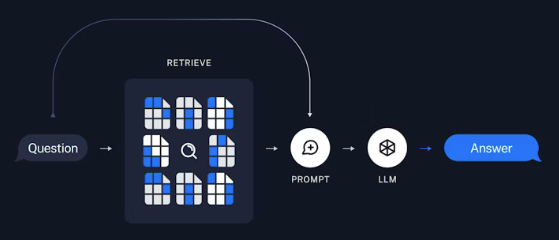

The retrieval and generation process consists of the following steps:

1. **Retrieve**: Given a user input, relevant chunks are retrieved from storage.
2. **Generate**: A model produces an answer using a prompt that includes both the question with the retrieved data

In [106]:
query = "What results does the RAG system achieve on the TriviaQA dataset?"
results = vectorstore.similarity_search(query, k=3)

In [107]:
results

[Document(metadata={'source': '2005.11401v4.pdf'}, page_content='For open-domain QA, multiple answer annotations are often available for a given question. These\nanswer annotations are exploited by extractive models during training as typically all the answer\nannotations are used to ﬁnd matches within documents when preparing training data. For RAG, we\nalso make use of multiple annotation examples for Natural Questions and WebQuestions by training\nthe model with each (q, a) pair separately, leading to a small increase in accuracy. For TriviaQA,\nthere are often many valid answers to a given question, some of which are not suitable training targets,\nsuch as emoji or spelling variants. For TriviaQA, we ﬁlter out answer candidates if they do not occur\nin top 1000 documents for the query.\nCuratedTrec preprocessing\nThe answers for CuratedTrec are given in the form of regular expres-\nsions, which has been suggested as a reason why it is unsuitable for answer-generation models [20].')

In [108]:
from langchain_ollama import OllamaLLM

In [109]:
llm = OllamaLLM(model="mistral:7b-instruct")

In [110]:
context = "\n\n".join(doc.page_content for doc in results)

In [113]:
prompt = f"""
Use the following context to answer the question.

Context:
{context}

Question:
{query}

Answer:
"""

In [114]:
answer = llm.invoke(prompt)

In [115]:
answer

' The RAG system achieves some improvement in accuracy on the TriviaQA dataset, but it filters out answer candidates that do not occur in top 1000 documents for the query due to the presence of many valid answers, some of which are not suitable training targets such as emoji or spelling variants.'

### Agentic RAG (Tool-Based Retrieval)

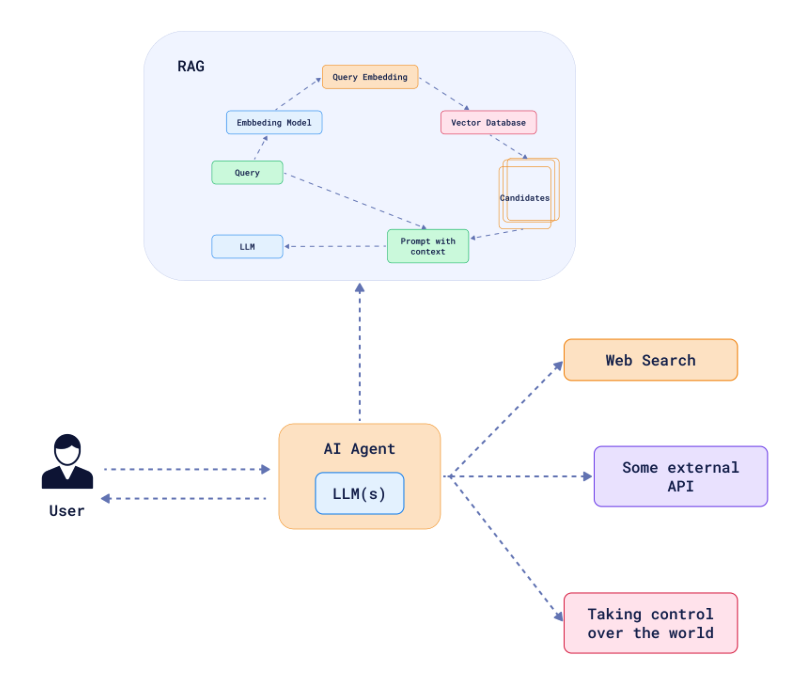

Agentic RAG extends traditional RAG by introducing agents that actively control the retrieval and generation process. Rather than following a fixed pipeline, the agent decides how a query should be handled. Tools play a central role in this approach, enabling the agent to access external resources such as vector databases for document retrieval, web search for up-to-date information, custom functions, and external APIs. Based on the query and its intermediate reasoning steps, the agent selects and invokes the appropriate tools—potentially using multiple tools in sequence—before generating the final response.

In [143]:
from langchain.chains import RetrievalQA
from langchain.agents import Tool
from langchain.agents import initialize_agent, AgentType

In [145]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

rag_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    return_source_documents=False
) 

def retrieve_documents(query: str) -> str:
    result = rag_chain.invoke({"query": query})
    return result["result"]

document_tool = Tool(
    name="DocumentRetriever",
    func=retrieve_documents,
    description="Use this tool to answer questions using the indexed PDF documents."
)

In [146]:
def calculator(expression: str) -> str:
    """Evaluate a mathematical expression."""
    try:
        return str(eval(expression))
    except Exception:
        return "Invalid expression."

calculator_tool = Tool(
    name="Calculator",
    func=calculator,
    description="Use this tool to solve mathematical expressions."
)

In [147]:
def weather_tool(location: str) -> str:
    """Mock weather tool."""
    return f"The weather in {location} is sunny and 23°C."

weather_tool = Tool(
    name="WeatherTool",
    func=weather_tool,
    description="Use this tool to get weather information for a location."
)

In [148]:
tools = [document_tool, calculator_tool, weather_tool]

agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent_type=AgentType.CONVERSATIONAL_REACT_DESCRIPTION,
    verbose=True,
    handle_parsing_errors=True
)

In [149]:
agent.run("What is RAG?")



> Entering new AgentExecutor chain...
 The question asks for the meaning of 'RAG'. This information might be available in one of the indexed PDF documents. So, I will use the DocumentRetriever tool.

Action: DocumentRetriever
Action Input: what is RAG
Observation:  The passage does not directly provide an answer to the question "What is RAG?" as it refers to RAG (Retrieval-augmented Generation) as a model, but not as an acronym. Without additional context or information, it's impossible to determine what RAG stands for based on this text alone.
Thought: I could not find the meaning of 'RAG' from the available documents. To further clarify this, I would suggest looking up a comprehensive dictionary or encyclopedia online. However, since that is beyond my capabilities as a text-based AI, I am unable to provide the exact meaning of 'RAG' in this context.
Observation: Invalid Format: Missing 'Action:' after 'Thought:
Thought: I apologize for the confusion. To find the meaning of 'RAG', I

'RAG refers to Retrieval-augmented Generation, a model used for open-domain question answering that combines retrieval and generation components.'

In [140]:
agent.run("What is 12*17/2?")



> Entering new AgentExecutor chain...
 This question requires mathematical calculations. No document retrieval or weather information is needed here.

Action: Calculator
Action Input: "12*17/2"
Observation: 102.0
Thought: I now know the final answer.
Final Answer: The result of the calculation 12*17/2 is 102.0.

> Finished chain.


'The result of the calculation 12*17/2 is 102.0.'

In [141]:
agent.run("What’s the weather in Skopje today?")



> Entering new AgentExecutor chain...
 I need to use WeatherTool to get the current weather information for Skopje.
Action: WeatherTool
Action Input: Skopje
Observation: The weather in Skopje is sunny and 23°C.
Thought: I now know the final answer.
Final Answer: The weather in Skopje today is sunny with a temperature of 23°C.

> Finished chain.


'The weather in Skopje today is sunny with a temperature of 23°C.'

### Agentic RAG with Web Search

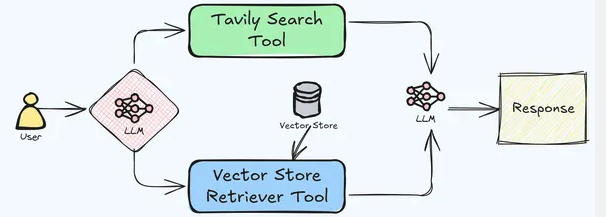

The following example illustrates an Agentic RAG workflow where the language model decides to use an external web search tool to answer a user query.

1. **User Query** – The user provides a question.
2. **LLM Reasoning** – The LLM decides whether external information is needed.
3. **Tool Invocation** – The Tavily Web Search tool is invoked when external data is needed.
4. **Knowledge Retrieval** – Relevant and up-to-date information is fetched from the web.
5. **Response Generation** – The LLM generates the final answer using the retrieved information.

In [ ]:
from langchain.agents import initialize_agent, AgentType
from langchain.tools import Tool
from langchain_tavily import TavilySearch

import os
os.environ["TAVILY_API_KEY"]=""

In [153]:
tavily_search = TavilySearch(max_results=3)

tools = [
    Tool(
        name="TavilyWebSearch",
        func=tavily_search.run,
        description="Search the web and return summarized results."
    )
]

agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True
)

In [154]:
agent.run("Latest news about AI in 2025")



> Entering new AgentExecutor chain...
 To find the latest news about AI in 2025, I need to perform a web search.

Action: TavilyWebSearch
Action Input: "Latest news about AI in 2025"
Observation: {'query': 'Latest news about AI in 2025', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://www.crescendo.ai/news/latest-ai-news-and-updates', 'title': 'The Latest AI News and AI Breakthroughs that Matter Most: 2025', 'content': 'Summary: Xiaomi has announced a next-gen AI voice model optimized for in-car and smart home experiences. The model features faster response times, offline', 'score': 0.9363841, 'raw_content': None}, {'url': 'https://www.mckinsey.com/capabilities/quantumblack/our-insights/the-state-of-ai', 'title': 'The state of AI in 2025: Agents, innovation, and transformation', 'content': 'The latest McKinsey Global Survey on the state of AI reveals a landscape defined by both wider use—including growing proliferation of agentic AI', 'score': 

'In 2025, Xiaomi announced a next-gen AI voice model for smart homes and cars with faster response times and offline capabilities. Google also made significant AI investments in areas like economic opportunity, scientific research, and real-world problem solutions. The latest McKinsey Global Survey highlights the widespread use of AI, including agentic AI, as well as challenges such as data privacy concerns and the need for increased regulations.'